<a href="https://colab.research.google.com/github/ayakow1/ttic31220-japanparliament-analysis/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [ ]:
!pip install mecab-python3 unidic-lite
!pip install japanize-matplotlib
!pip install googletrans==3.1.0a0

import pandas as pd
import MeCab
import gensim
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import sqlite3
import pandas as pd
from wordcloud import WordCloud
from googletrans import Translator
from tqdm import tqdm
import json


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.6/581.6 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=c47a27ee3c51a13c0c8e55b398c3c99d4f2806a2c52e6be45f10fba7d17ae45b
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 98.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=08f5592fcbbd3d628c47331f54222eb42b1026b98c411d411bdc136f526c5245


In [ ]:
# Test

translator = Translator()
translated = translator.translate('こんにちは、世界！')

# the translate method returns an object
print(translated.text)

Hello World!


In [ ]:
# Import Data

from google.colab import drive
drive.mount("/content/drive")

use_raw = False
if use_raw:
    name = "raw_speech"
else:
    name = "speech"
conn = sqlite3.connect(f'/content/drive/MyDrive/議事録/{name}.db')
all = pd.read_sql_query(f'''SELECT * FROM {name} WHERE speech_date >= '2022-01-01' AND speech_date <= '2023-04-31' ''', conn)
docs = all['speech'].to_list()
conn.close()


Mounted at /content/drive


# Hypertuning

In [ ]:
# docs_lda = []
# for d in docs:
#     docs_lda.append(d.split(" "))
docs_lda = [d.split(" ") for d in docs]
dictionary = gensim.corpora.Dictionary(docs_lda)
corpus = [dictionary.doc2bow(doc) for doc in docs_lda]


In [ ]:
#Metrics for Topic Models

start = 2
limit = 100
step = 4

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = gensim.models.CoherenceModel(
        model=lda_model, texts=docs_lda, corpus=corpus, dictionary=dictionary, coherence='c_npmi')
    coherence_vals.append(coherence_model_lda.get_coherence())


100%|██████████| 25/25 [39:55<00:00, 95.81s/it] 


In [ ]:
print(coherence_vals)
print(perplexity_vals)


[0.005723222352006448, 0.016595159988431345, 0.021659360112361643, 0.029994155354644232, 0.03112454784911454, 0.016369355861390565, 0.010344021793529437, 0.025150876270325983, 0.016952736721604918, 0.016323172813821108, -0.007615006578587092, 0.004284872122658231, -0.011991669541231065, -0.005432934794113143, -0.03758922765784995, -0.03463361554244037, -0.039955343511409676, -0.04701458643561269, -0.05343794353101334, -0.056561554382790646, -0.05442151838509953, -0.055551735096655244, -0.0662156065164857, -0.06246312296369739, -0.07748952011314943]
[330.98497276756046, 322.7408266948966, 430.24266749076196, 742.2035209835002, 958.3468139173225, 1258.7347404257284, 1649.1207785472839, 2161.6534331316693, 2835.2828936709843, 3702.7749899562327, 4930.832397999278, 6468.723939987421, 8559.029137414518, 11160.091132822774, 14855.1737741171, 19672.663979711262, 25804.403771646055, 34247.11394576675, 45636.384695165456, 60009.73146137037, 78773.53823271154, 104972.42161345293, 138015.60034087

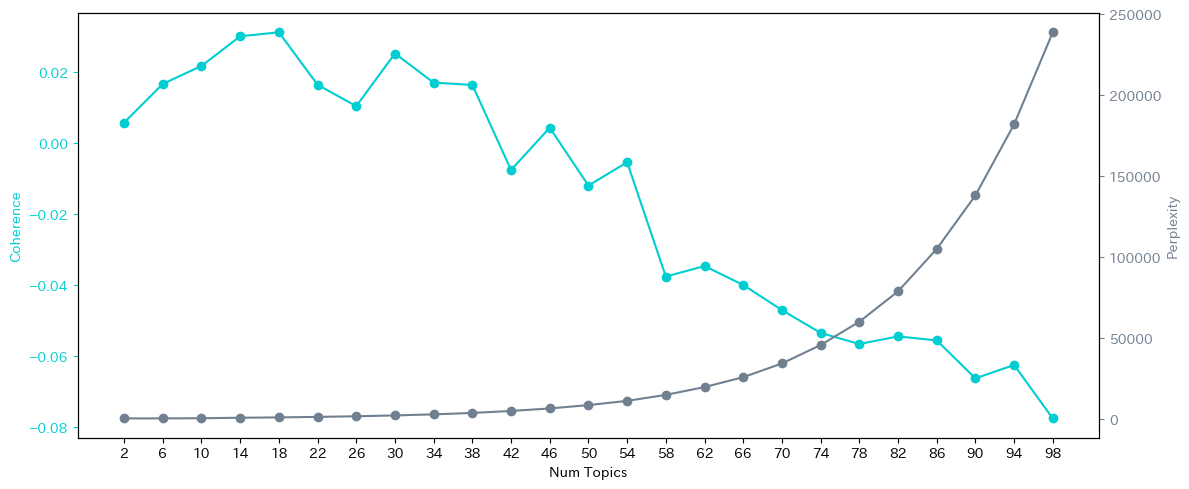

<Figure size 640x480 with 0 Axes>

In [ ]:
# evaluation
x = range(start, limit, step)

fig, ax1 = plt.subplots(figsize=(12,5))

# coherence
c1 = 'darkturquoise'
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

# perplexity
c2 = 'slategray'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

# Vis
ax1.set_xticks(x)
fig.tight_layout()
plt.show()

# save as png
plt.savefig('/content/drive/MyDrive/議事録/LDA/models/metrics_processed_large.png') 

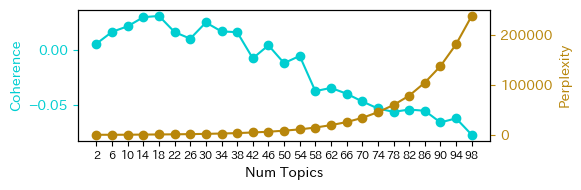

<Figure size 640x480 with 0 Axes>

In [ ]:
# evaluation

x = range(start, limit, step)

fig, ax1 = plt.subplots(figsize=(6,2))

# coherence
c1 = 'darkturquoise'
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.tick_params(axis='x', labelsize=8)
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

# perplexity
# c2 = 'slategray'
c2 = 'darkgoldenrod'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

# Vis
ax1.set_xticks(x)
fig.tight_layout()
plt.show()

# save as png
plt.savefig('/content/drive/MyDrive/議事録/LDA/models/metrics_processed_small.png') 

In [ ]:
print(coherence_vals)
print(perplexity_vals)


[0.005723222352006448, 0.007276549855556802, 0.014893917877705288, 0.0210485278420704, 0.016595159988431345, 0.018199767138745746, 0.02457084096382981, 0.022554947735330427, 0.021659360112361643, 0.03184752494385213, 0.04243549060315215, 0.04148414489953023, 0.029994155354644232, 0.037421015171871984, 0.01358863438851887, 0.023579408316627214, 0.03112454784911454, 0.024416561767419992, 0.024448770936030328]
[330.98497276756046, 324.07074947912986, 316.5948160801704, 315.3918290835145, 322.7408266948966, 335.97787021368396, 348.73321816724535, 385.0236461406895, 430.24266749076196, 504.7751581956286, 586.9864669031163, 667.1030348726138, 742.2035209835002, 794.9677668110415, 842.3031040332988, 903.6560341330083, 958.3468139173225, 1036.3852334909993, 1112.3180902212155]


In [ ]:
method = "npmi"
name = "coherence_vals"
n_topics = "2to10"

file_path = f"/content/drive/MyDrive/議事録/LDA/models/{method}_{name}_{n_topics}.json"
with open(file_path, "w") as f:
    json.dump(coherence_vals, f)

name = "perplexity_vals"
file_path = f"/content/drive/MyDrive/議事録/LDA/models/{method}_{name}_{n_topics}.json"
with open(file_path, "w") as f:
    json.dump(perplexity_vals, f)


# Run Model

In [ ]:
n_topics = 30
lda = gensim.models.LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=n_topics, 
                minimum_probability=0.001,
                passes=20, 
                update_every=0, 
                chunksize=10000,
                random_state=1
                )


In [ ]:
learned = False
# learned = True

if use_raw:
    file_path = f"/content/drive/MyDrive/議事録/LDA/models/lda_unprocessed_{n_topics}.model"
else:
    file_path = f"/content/drive/MyDrive/議事録/LDA/models/lda_processed_{n_topics}.model"

if not learned:
    # saving model to disk.
    lda.save(file_path)
else:
    # loading model from disk
    lda = gensim.models.ldamodel.LdaModel.load(file_path)


In [ ]:
bound = lda.log_perplexity(corpus)
perplexity = np.exp(-bound)
print(perplexity)


3404.3101463403614


In [ ]:
# https://radimrehurek.com/gensim/models/coherencemodel.html

# cm = CoherenceModel(model=lda, corpus=common_corpus, coherence='u_mass')
# cm = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass') # https://www.baeldung.com/cs/topic-modeling-coherence-score
cm = gensim.models.CoherenceModel(
    model=lda, texts=docs_lda, corpus=corpus, dictionary=dictionary, coherence='c_npmi')

coherence = cm.get_coherence()
coherence


0.03479963223818177

In [ ]:
# lda.show_topic(3)

topic_words = [[words for words, _ in lda.show_topic(t)] 
               for t in range(60)]

topics = [
    ['human', 'computer', 'system', 'interface'],
    ['graph', 'minors', 'trees', 'eps']
]

# cm = CoherenceModel(topics=topics, corpus=common_corpus, dictionary=common_dictionary, coherence='u_mass')
cm = CoherenceModel(topics=topic_words, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence = cm.get_coherence()
coherence


IndexError: ignored

# Visualization

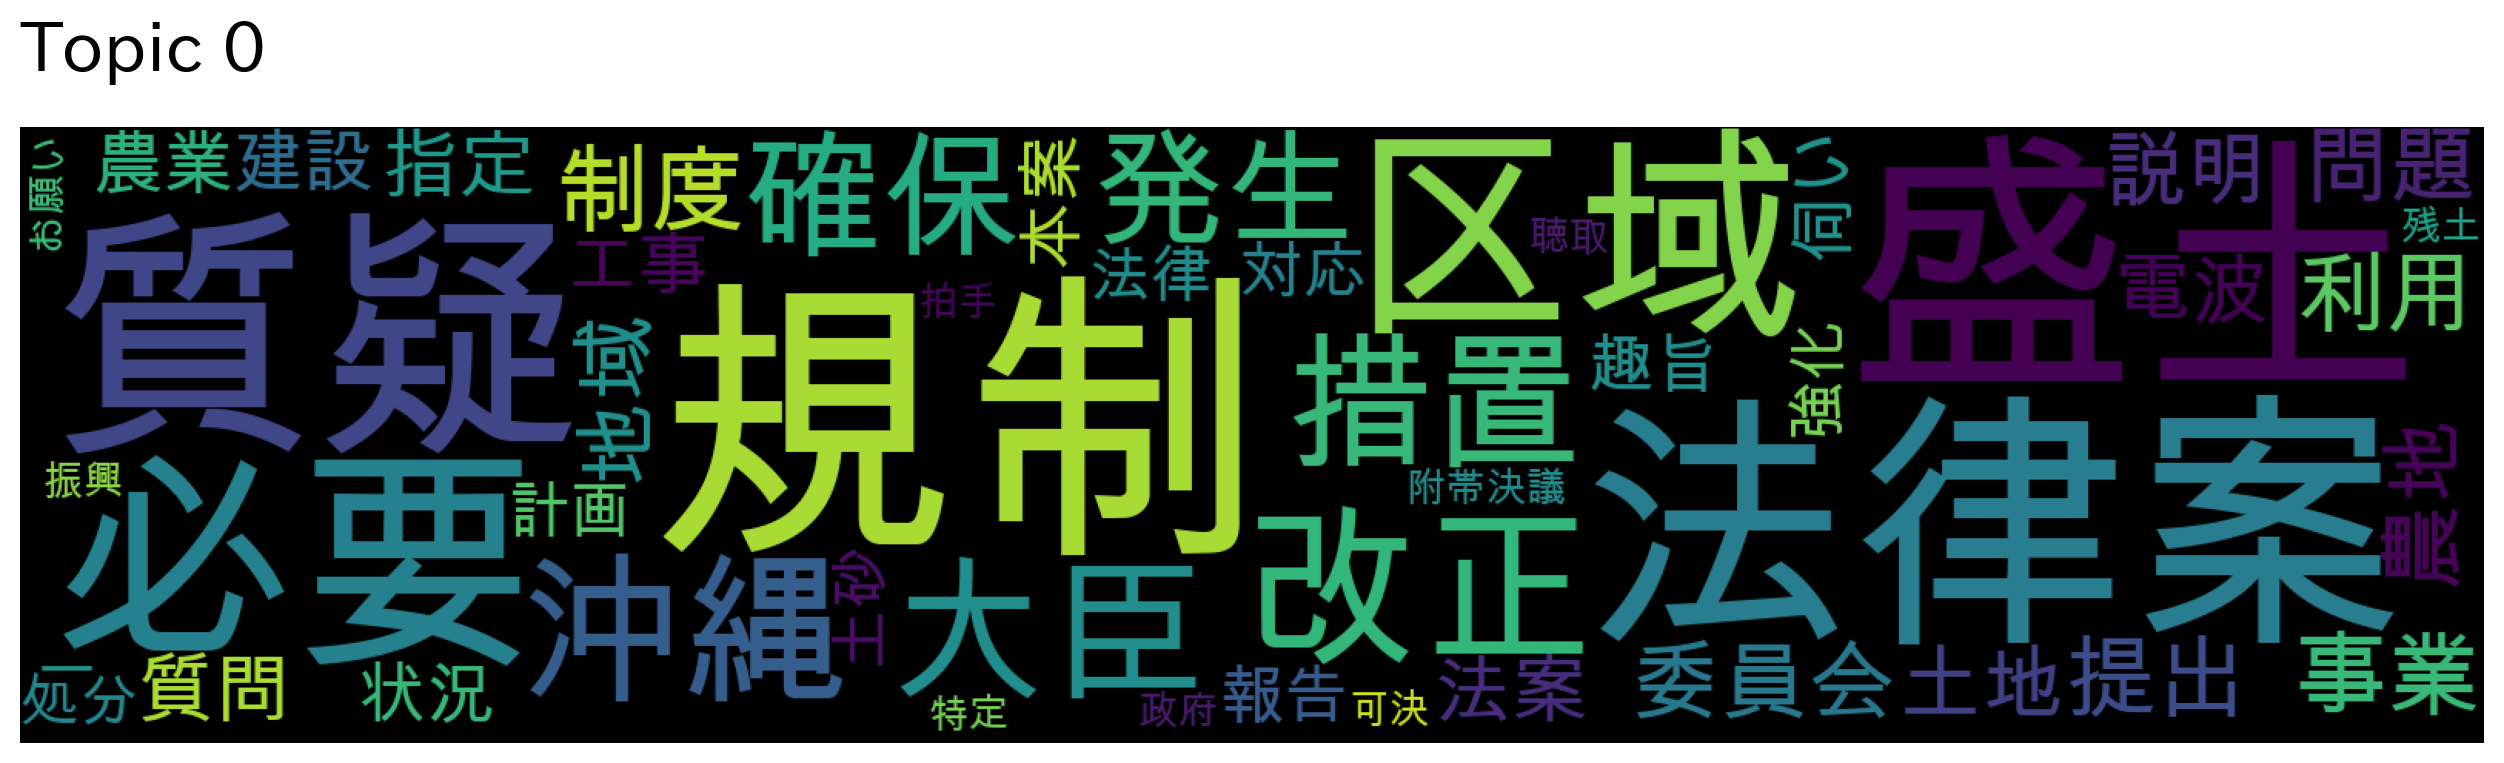

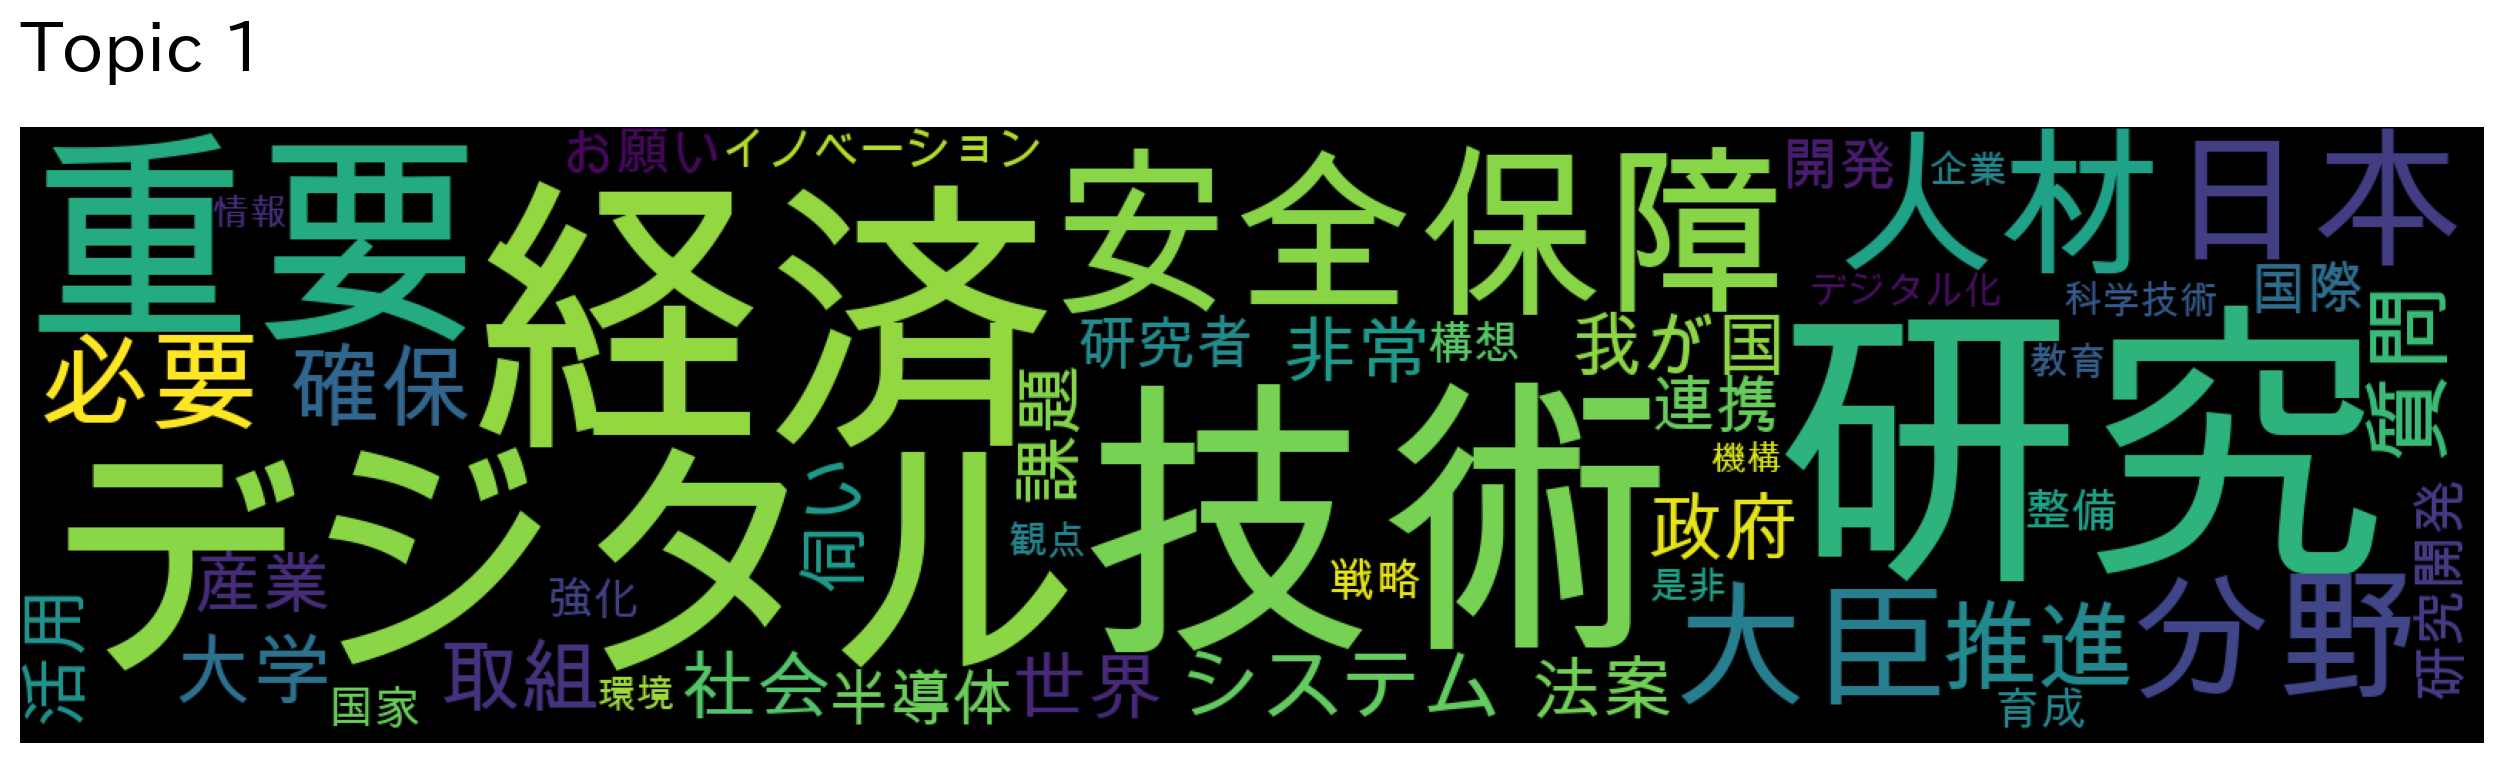

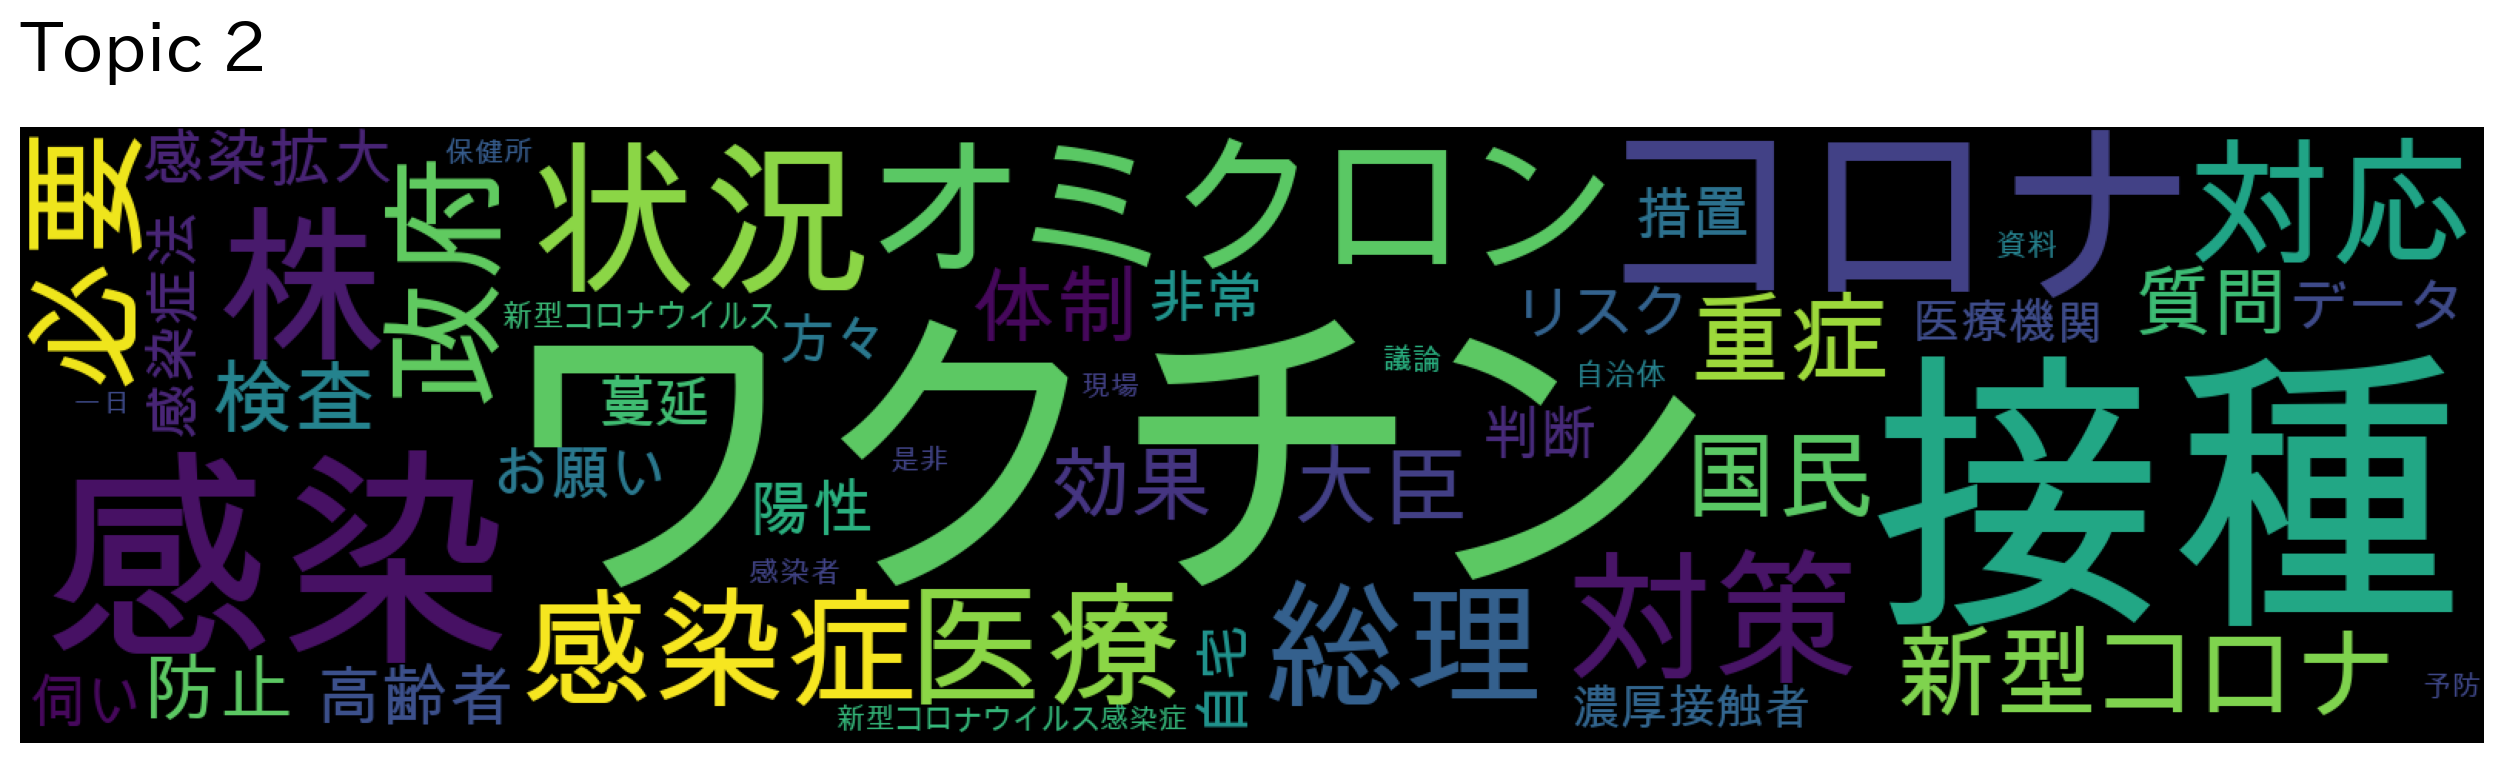

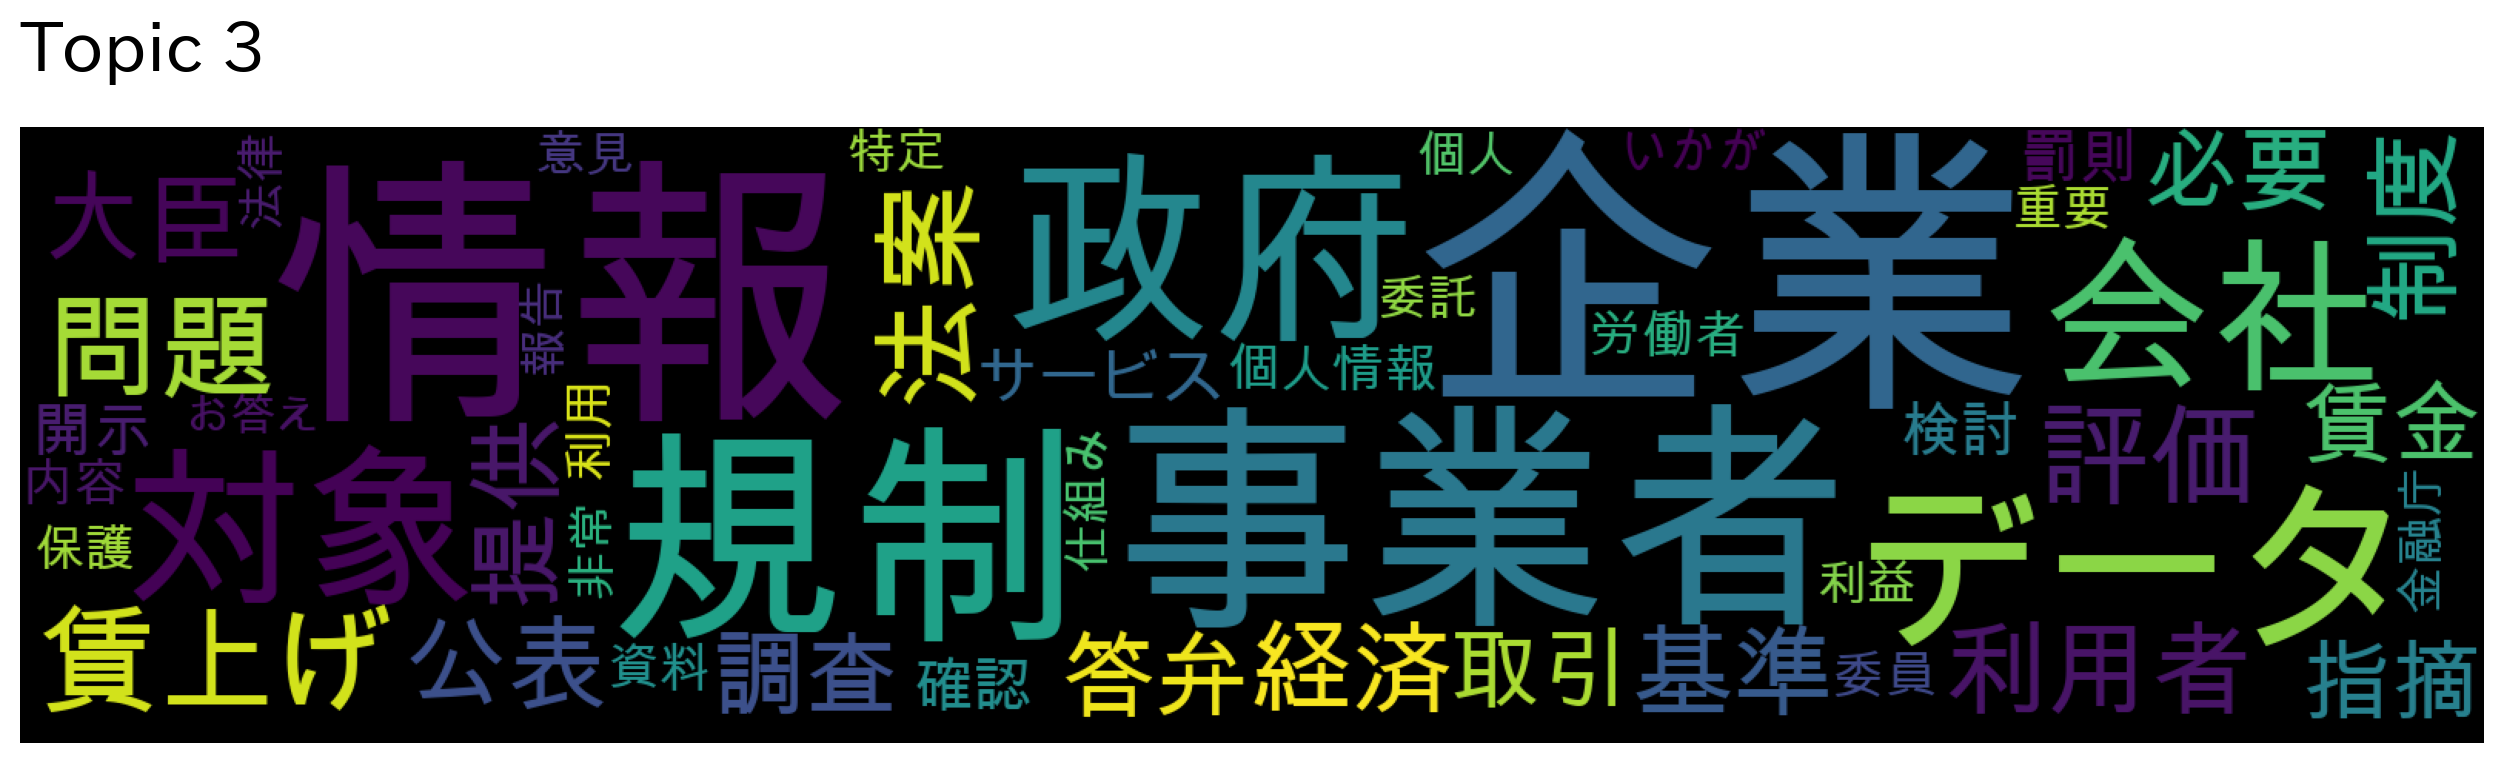

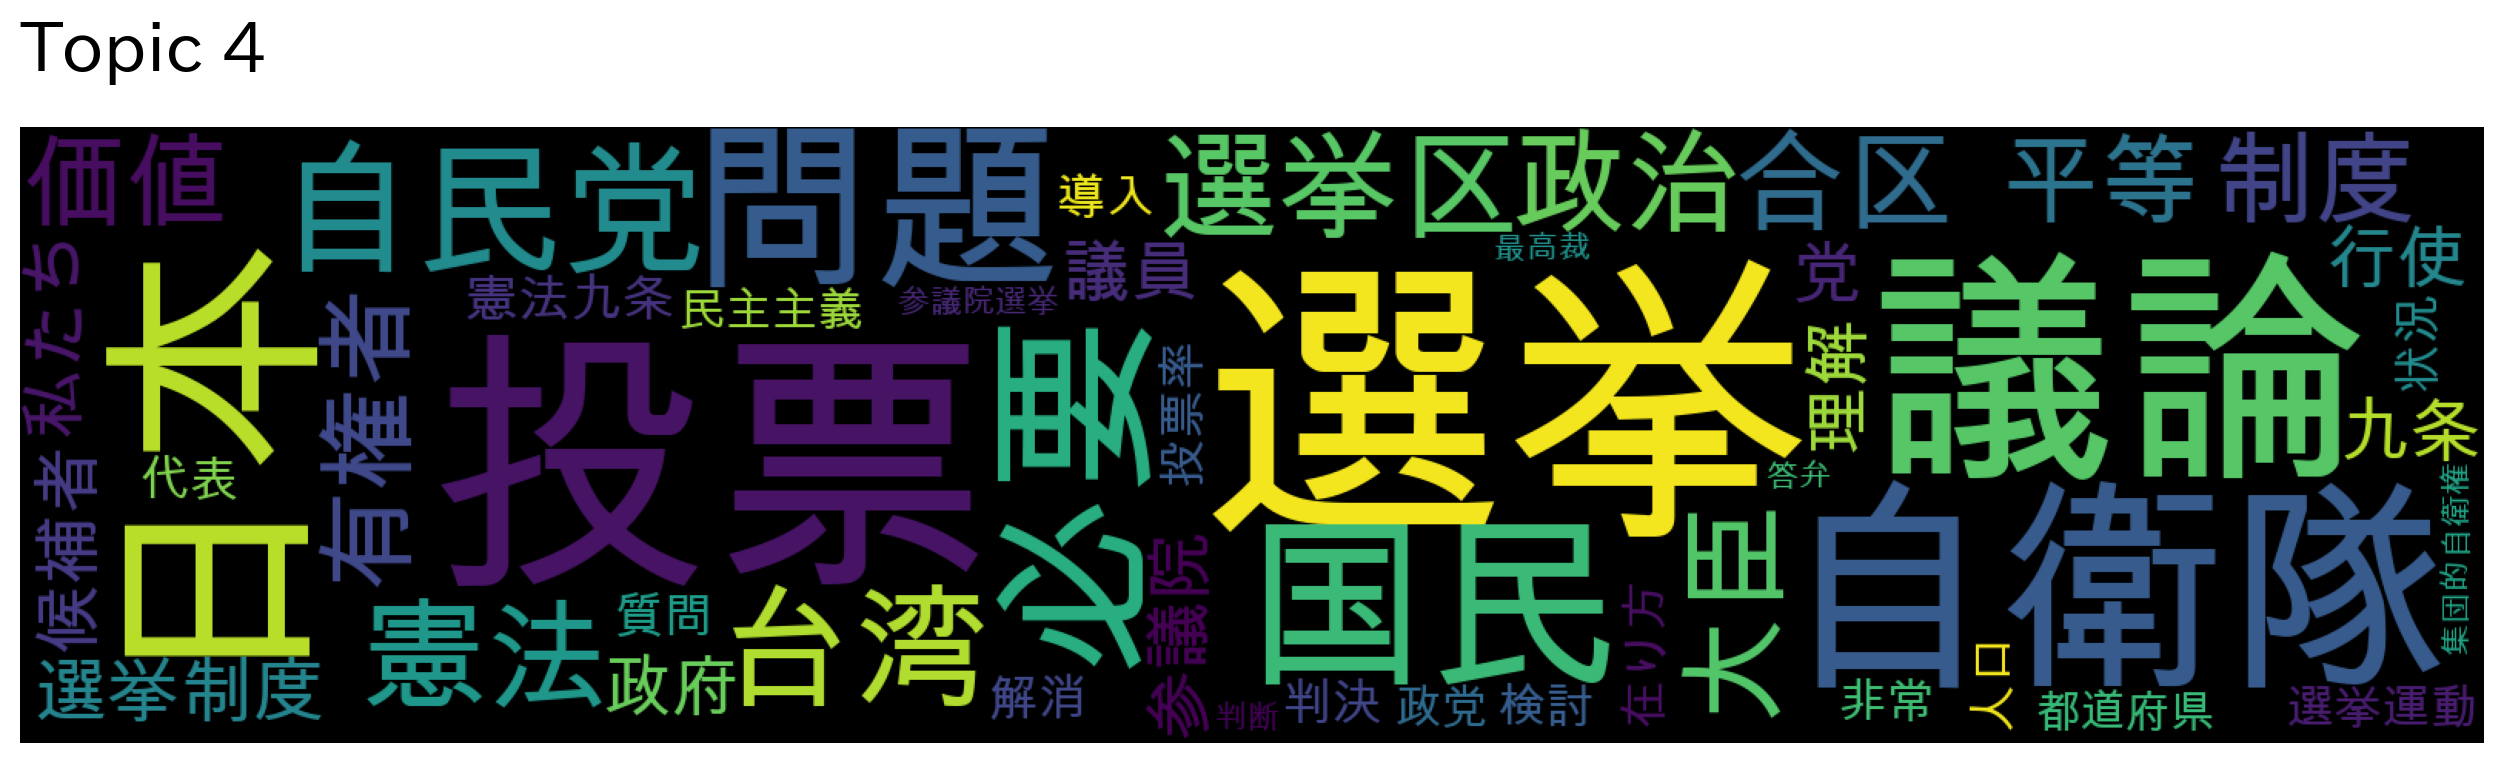

In [ ]:
num_clouds = 5
FONT_PATH = '/Library/Fonts/ipaexg.ttf'

for t in range(num_clouds):
    plt.figure(figsize=(16, 4), dpi=200)
    plt.axis("off")
    word_score_dict = dict(lda.show_topic(t, 50))
    plt.imshow(WordCloud(width=1600, height=400, mode='RGBA', background_color='black', \
     font_path='/content/drive/MyDrive/議事録/Arial Unicode.ttf', max_words=1000, max_font_size=200).generate_from_frequencies(word_score_dict))
    plt.title("Topic " + str(t), loc='left', fontsize=25, pad=20)
    plt.show()

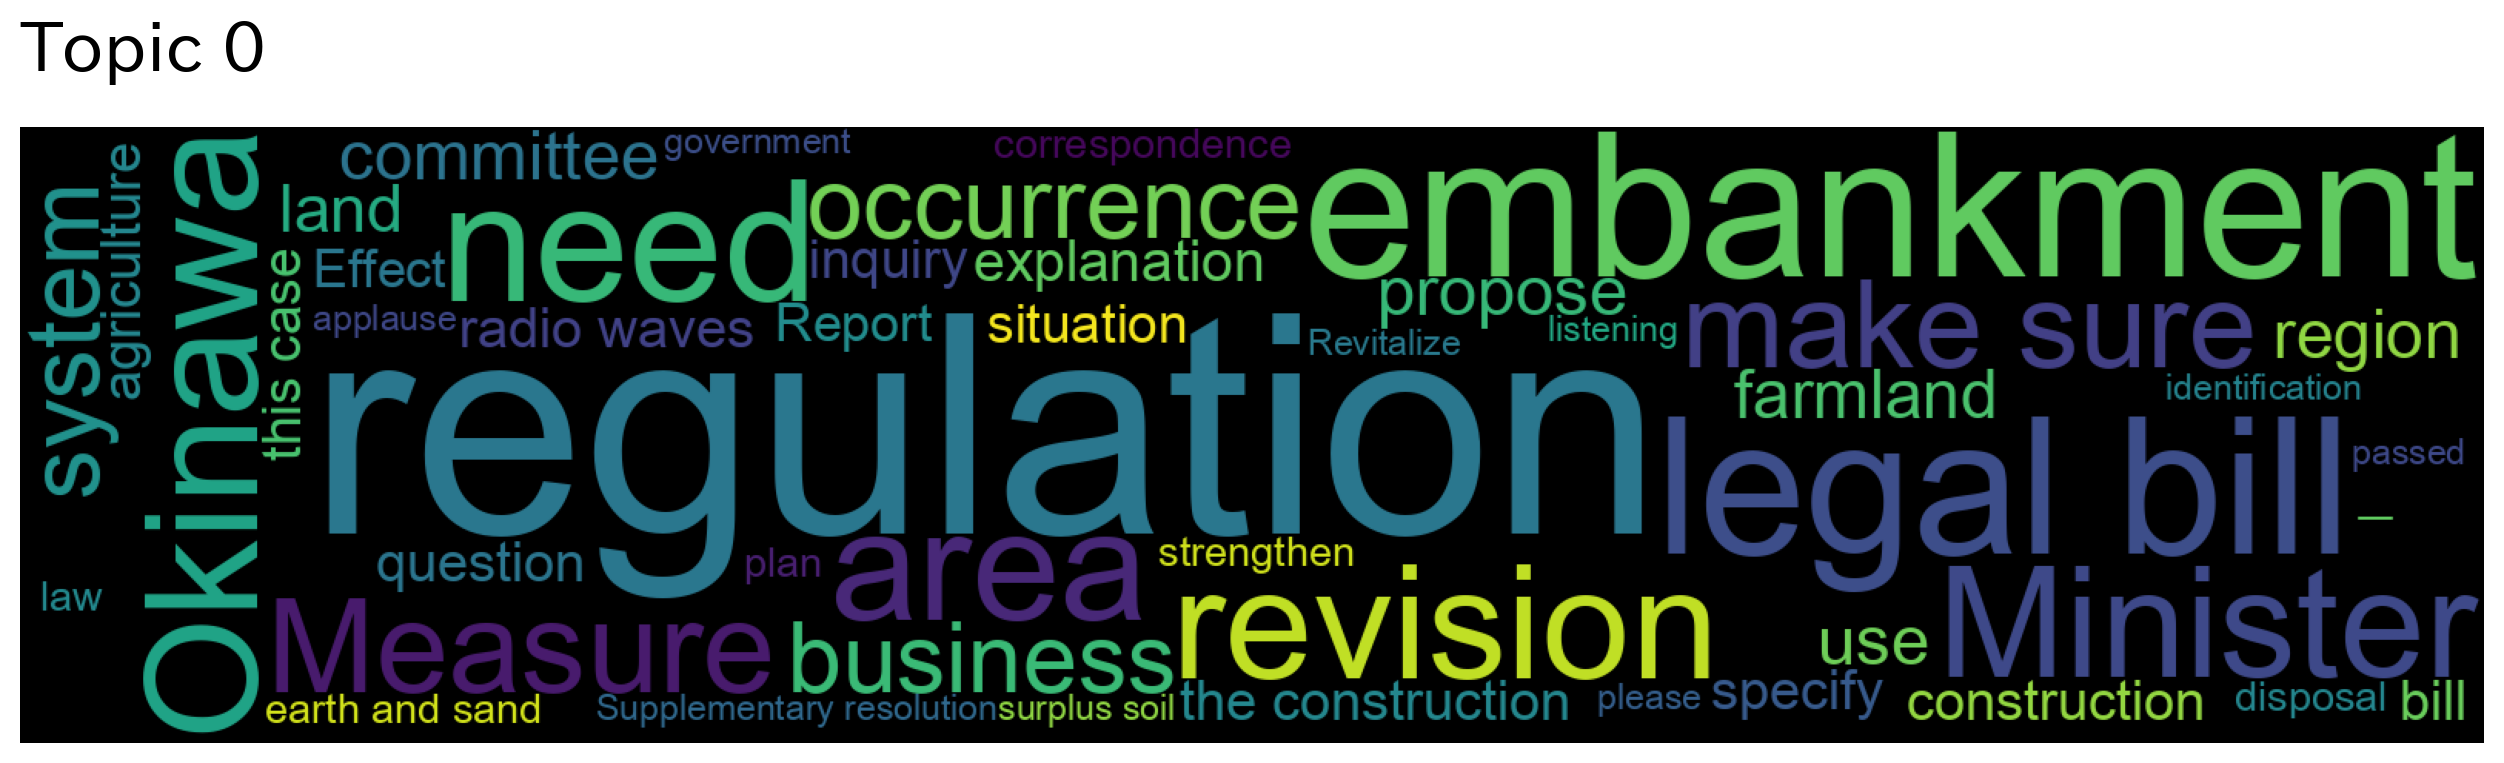

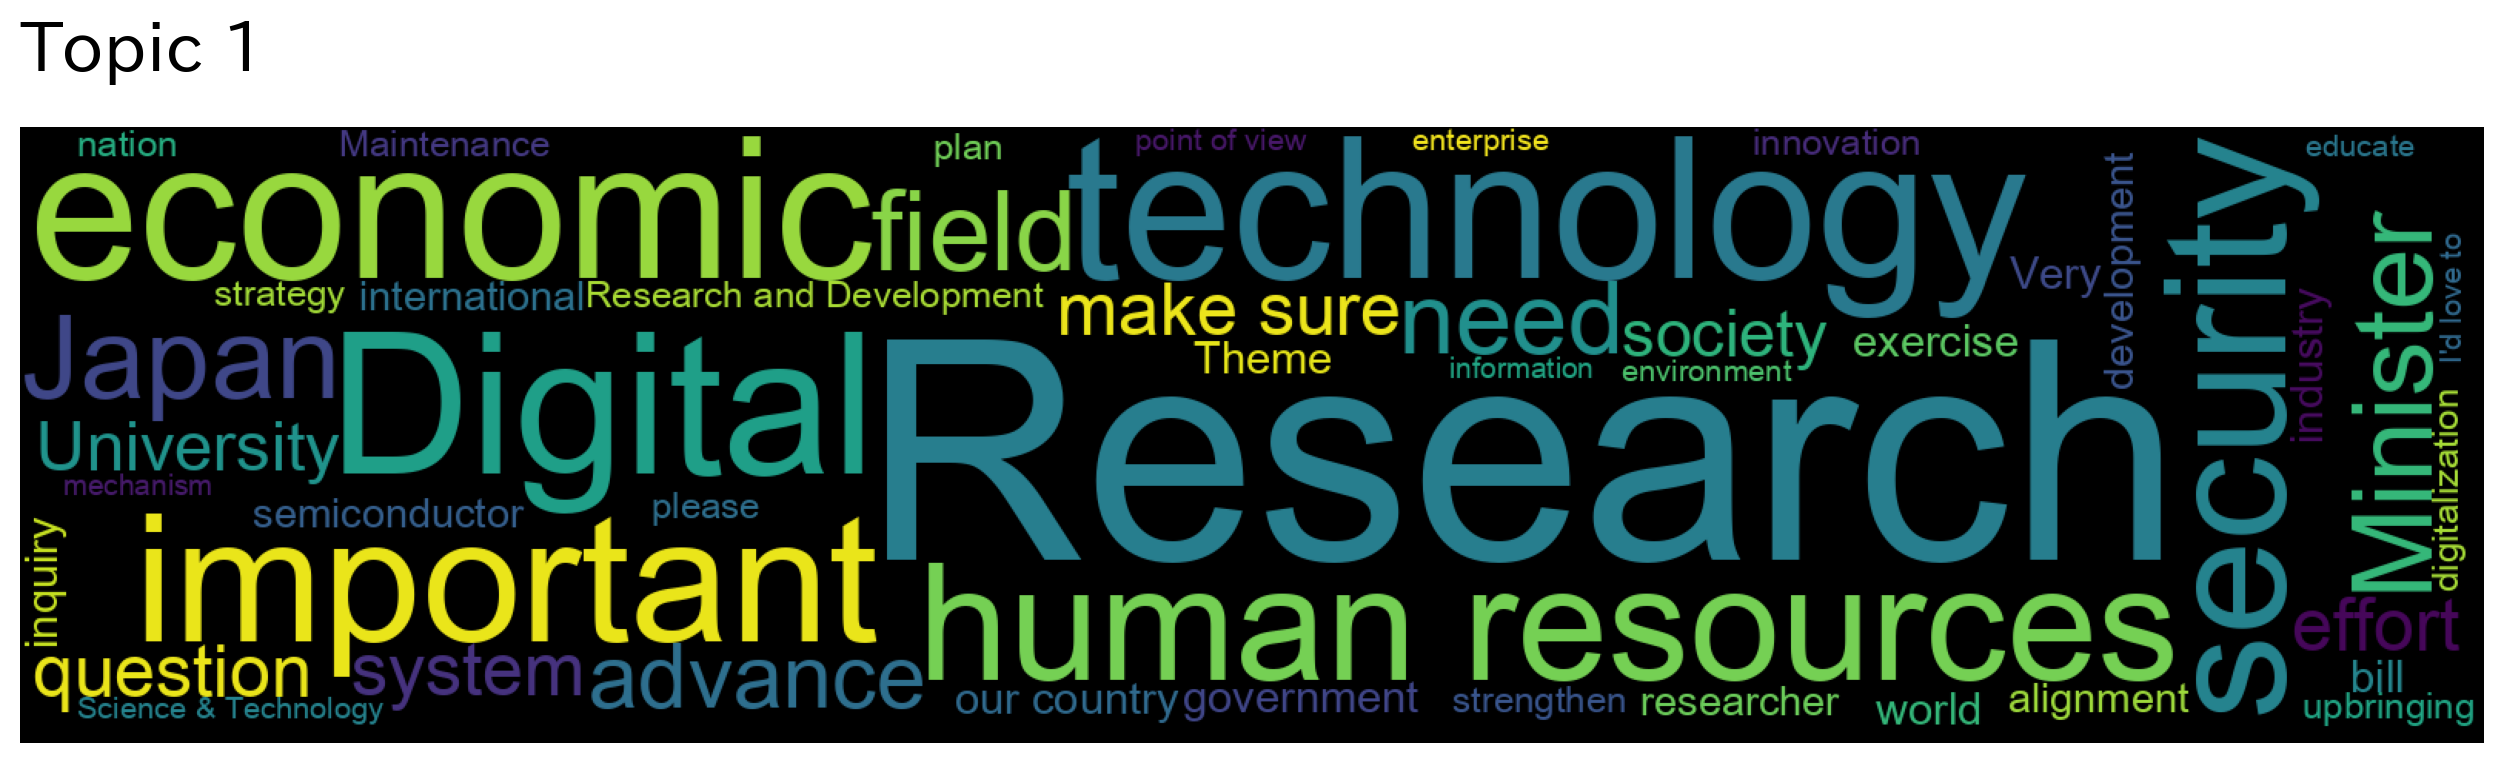

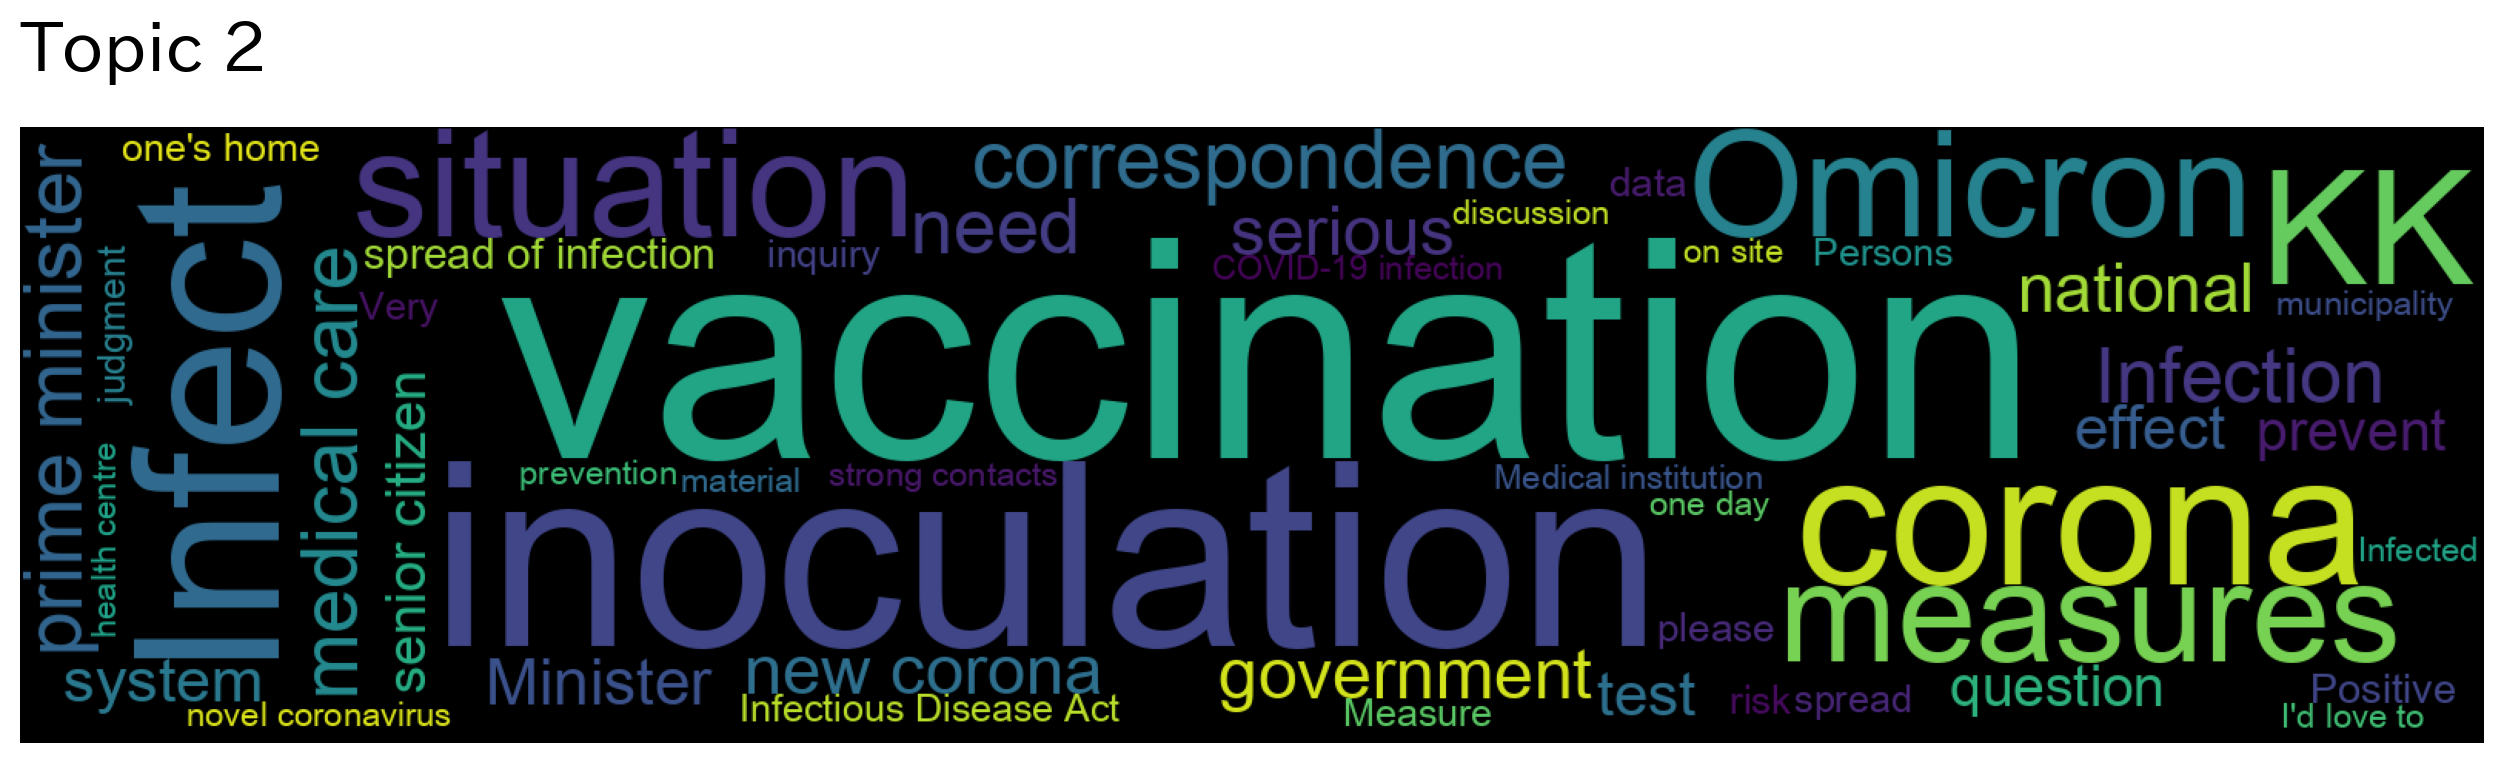

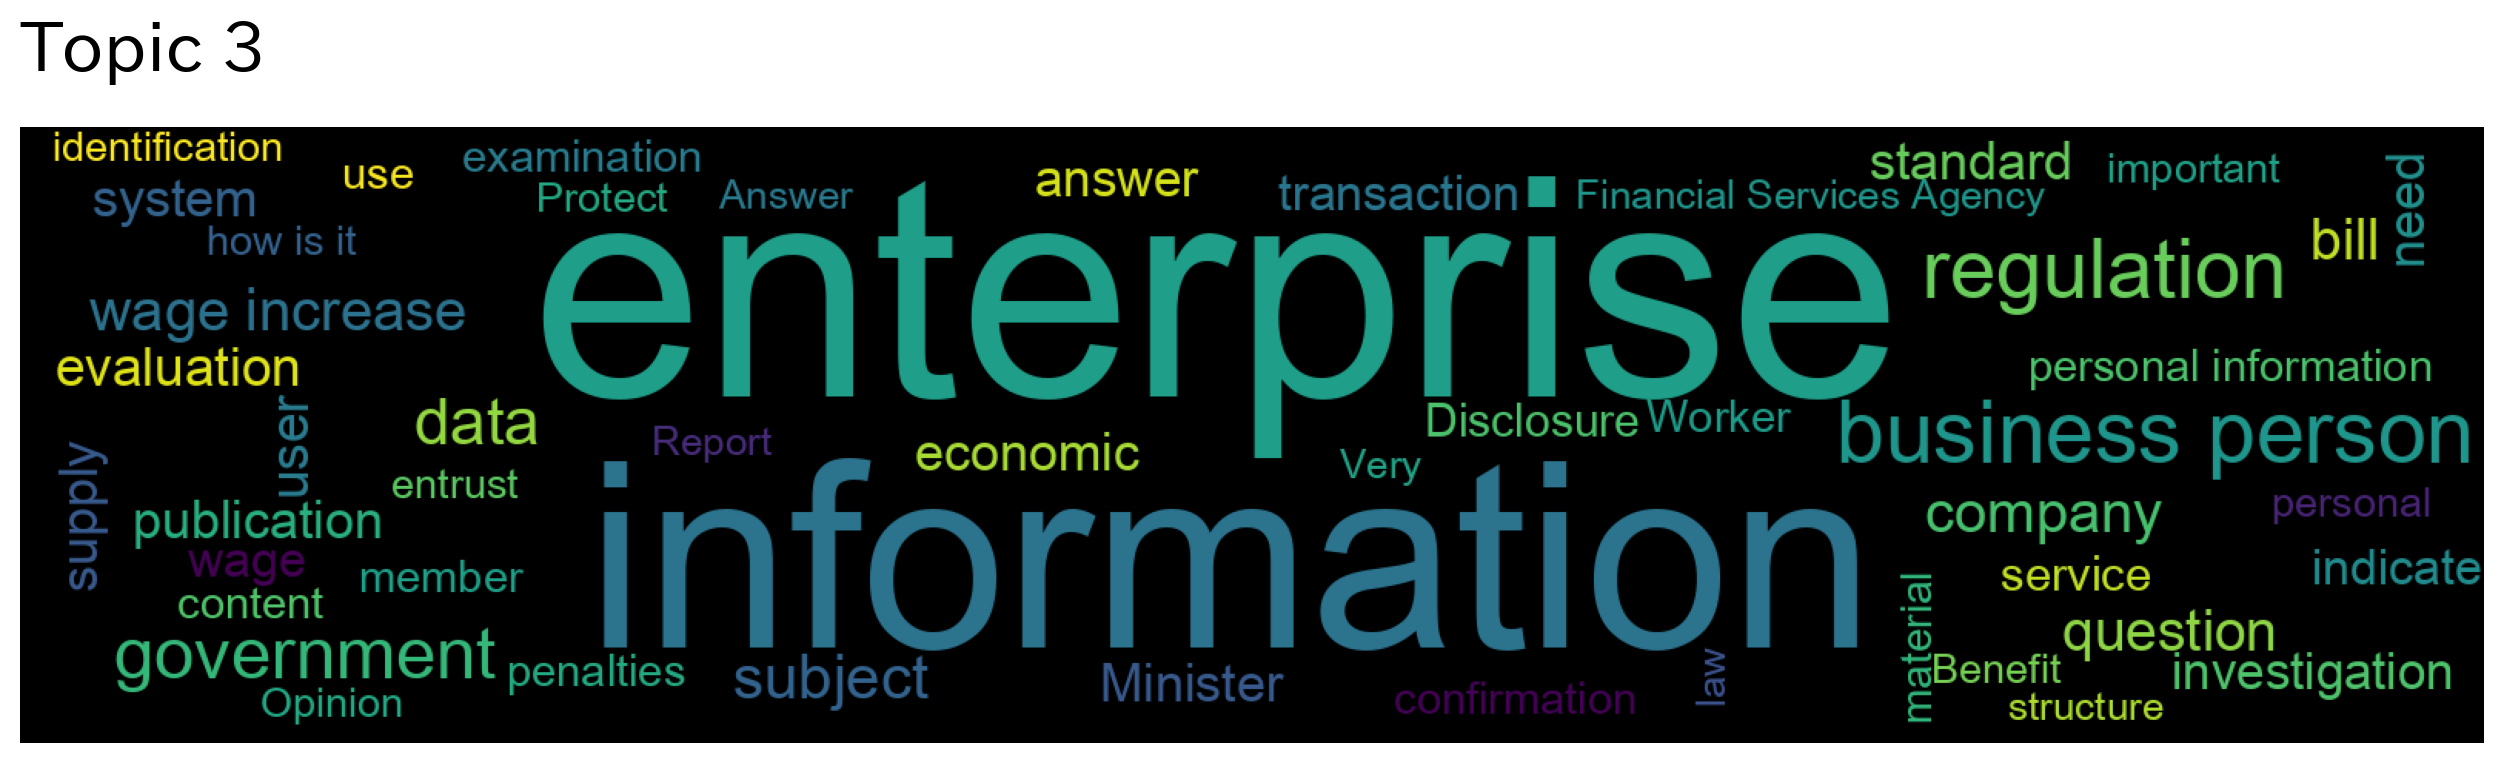

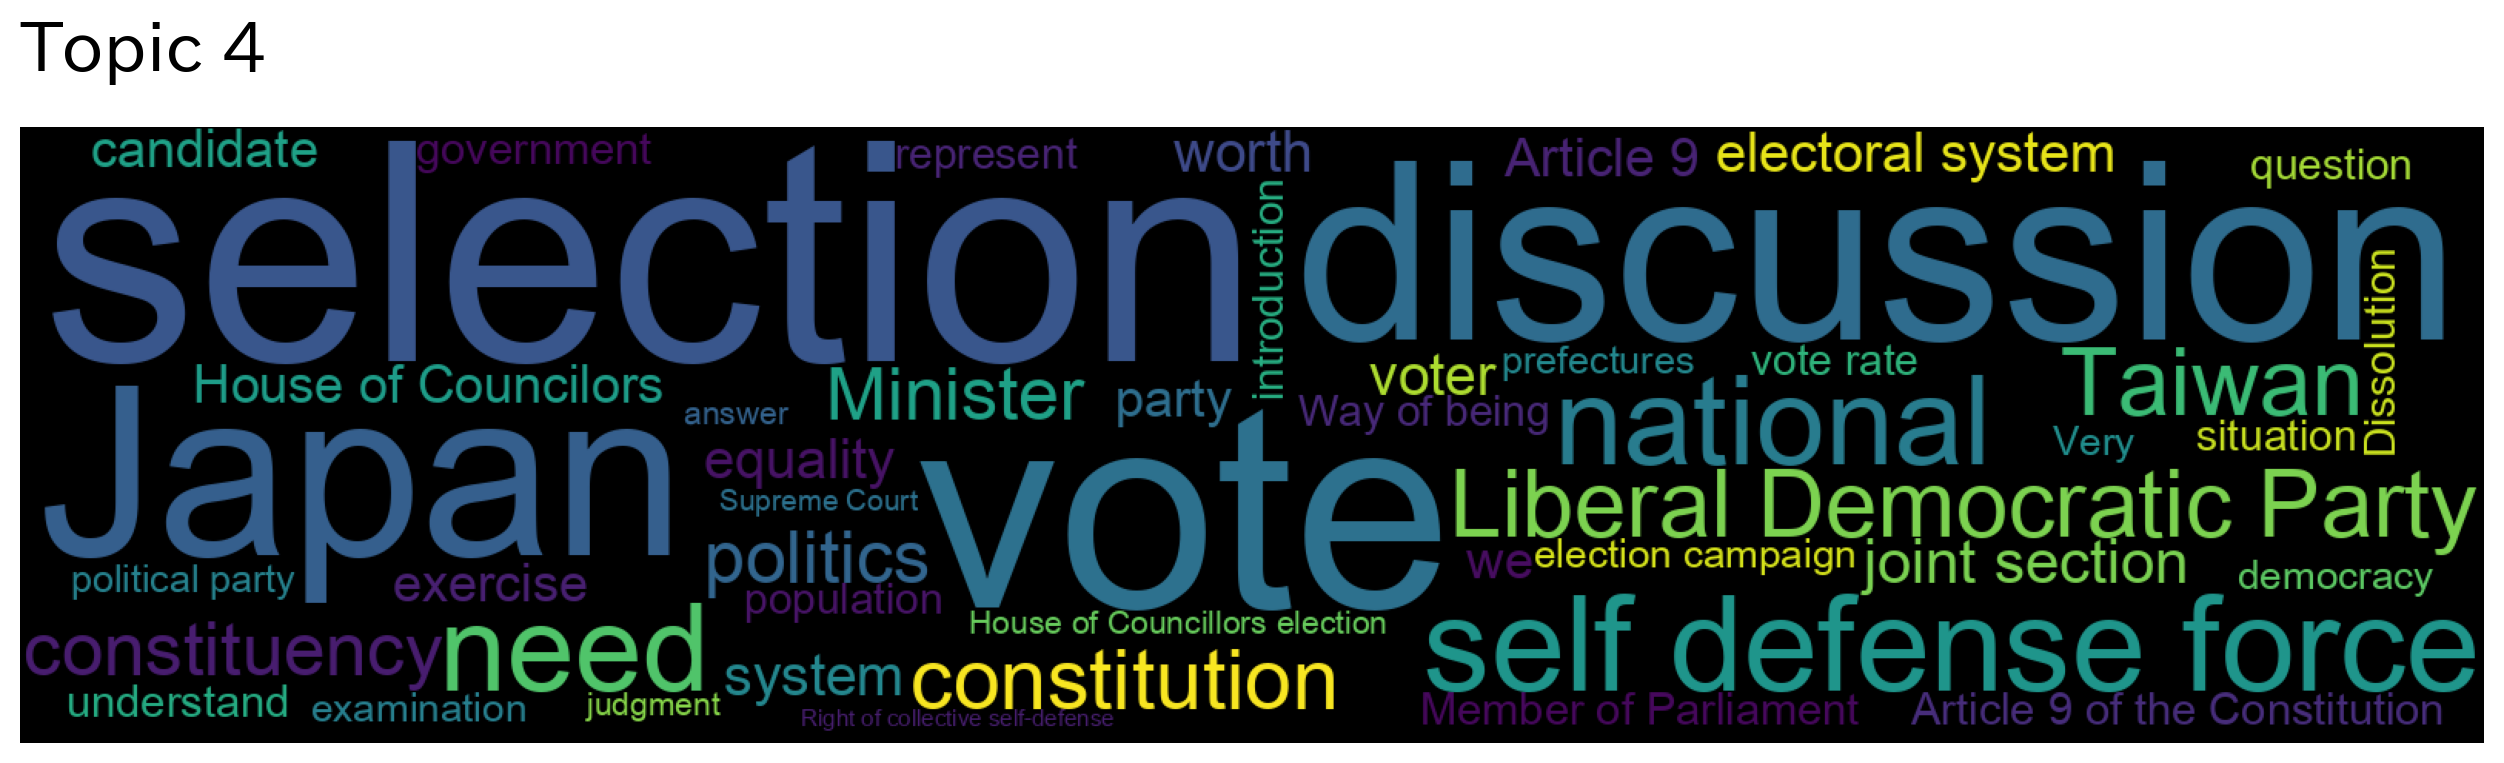

In [ ]:
num_clouds = 5
FONT_PATH = '/Library/Fonts/ipaexg.ttf'
translator = Translator()

for t in range(num_clouds):
    plt.figure(figsize=(16, 4), dpi=200)
    plt.axis("off")
    translated_topics = {}
    for k, v in lda.show_topic(t, 50):
        translated_topics[translator.translate(k).text] = v
    plt.imshow(WordCloud(width=1600, height=400, mode='RGBA', background_color='black', \
     font_path='/content/drive/MyDrive/議事録/Arial Unicode.ttf', max_words=1000, max_font_size=200).generate_from_frequencies(translated_topics))
    plt.title("Topic " + str(t), loc='left', fontsize=25, pad=20)
    plt.show()


In [ ]:
lists = []
for i in range(n_cluster):
    temp_df = pd.DataFrame(lda.show_topic(i),columns=["word","score"])
    temp_df["topic"] = i
    lists.append(temp_df)
topic_word_df = pd.concat(lists,ignore_index=True)
topic_word_df["rank"] = topic_word_df.groupby("topic")["score"].rank()
topic_word_df.pivot(index='topic', columns='rank', values='word')

rank   1.0        2.0   3.0    4.0    5.0         6.0     7.0    8.0    9.0   \
topic                                                                          
0        改正         拍手    本案      ー     提出         委員会      制度     質疑     電波   
1        取組         推進    社会     重要   システム          分野      技術     人材     研究   
2        資料        コロナ    状況     感染  オミクロン           株      効果    データ     接種   
3        男女         政府    情報     基準     労働          賃金      会社    労働者    賃上げ   
4        使用         国民    必要     日本     有効         安全性      制度     緊急    医薬品   
5        質問         養育    転換     博士     公募        雇い止め      開発     支援     委託   
6        職員         質問    規定     問題     必要         法務省      法律     制度     取得   
7        交換         調査    大臣     取引     大会          日本      質問   スポーツ     暗号   
8        廃止         地元    福島    皆さん     廃炉          事故      住民     原発    保険証   
9        事業         事件    所有     保存     問題          管理      記録     不明    所有者   
10       排出        利用者    取組  アンモニア    CO2  カーボンニュートラル      水素     削減     炭素   
11      保育士         環境    戦略     質問     処遇          取組      食料   有機農業     改善   
12      被災地         発生    復旧     離島     被災      東日本大震災      地震     被害     復興   
13       大臣        お願い    費用     代理     着席          国民     委員長     退席     負担   
14      法律案        侮辱罪    改正     目的     議論          政府      提出     質問     質疑   
15       対応         状況    質問     支援     難民         受入れ      方々     日本  ウクライナ   
16       充実         地域    措置     確保     実施          検討      制度     事業     必要   
17       質問      地方自治体   お願い   地方創生     交付         総務省      地域     大臣     地方   
18       対策         飼料    国内     状況     農家          農業      輸出     価格     輸入   
19      看護師         医師    大臣     医療     数字          調査  ガイドライン     問題     職員   
20      皆さん         質問    大変     伺い     事故          皆様      お話     意見     参考   
21      留学生         手続    重要     質問     問題          認識      非常   資本主義     裁判   
22       大変         日本   事業者    お願い     観光          支援    コロナ禍     状況     事業   
23       外交          米  外務大臣     政府     米軍          訓練     北朝鮮    自衛隊    我が国   
24       必要         措置    反対     地方    防衛費          確保      予算     財政     総理   
25     アメリカ  再生可能エネルギー    エネ     非常     炭素         我が国      中国  エネルギー     世界   
26       社会         意見   子育て      親     法案          政策    子供たち    こども     家庭   
27       CM         運動    放送   国民投票     着用     インターネット      規制    ネット     広告   
28       情報         診療   後遺症    厚労省     症状          医師    医療機関     治療     医療   
29      文化庁        お願い    非常     質問     先生          文化      大臣     資料    博物館   
30       整備       トラック   国交省     資料     公共          バス      鉄道     港湾     交通   
31       新築        データ    法案     断熱     性能         建築物      木材     基準    省エネ   
32       大変         問題    必要     仕事     状況          是非      方々     相談     支援   
33       所信         最後    質疑     議論     是非         お願い      問題     答弁     質問   
34       必要         医療    状況     国民     対応          感染      政府    コロナ     対策   
35       必要         質問   農水省     農家     状況          経営     担い手     地域     農地   
36       計画         施設    工事     災害     必要          盛土      発生     対策     地域   
37       非常       沖縄振興    問題     振興     資料          基地      復帰     県民    沖縄県   
38       出席      オンライン    意見     規定     国民          議員      必要     憲法     国会   
39      無償化         非常    高校     運転    委員会          期間      教育     議論     先生   
40       技術         原発    必要     確保     供給          政府      重要     法案   安全保障   
41       経済         状況    総理     質問    我が国          国民      侵略     日本  ウクライナ   
42       出演         指導    契約     教育     先生        子供たち     文科省     研修     教員   
43       状況       雇用保険    料金     導入  インボイス          給付      雇用     負担    事業者   
44       政府         賃金    日銀     政策     税制          所得      物価     経済     総理   
45       事務         報告    策定   都道府県     評価          取組      改革    市町村     調査   
46       検討         平成    統計     行政     名称          質問      申請     変更     資料   
47       条約         日本    同意     福祉     勧告          入院     当事者     国葬     障害   


In [ ]:
!pip install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, '/content/drive/MyDrive/議事録/LDA/lda_pyldavis.html')


/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
